<a href="https://colab.research.google.com/github/RohanSubramani/Miscellaneous/blob/main/rs4126_RL_HW1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import copy
import math
import random

# Part 1

Simulating probabilities using Beta distribution.

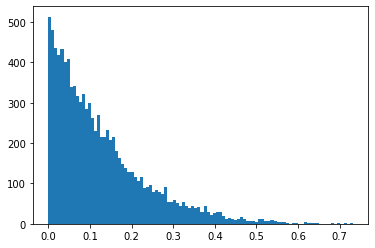

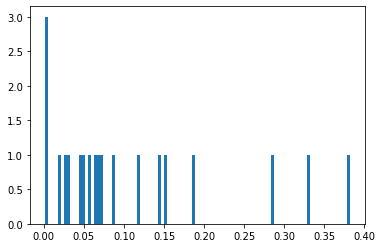

[0.00462143 0.04497795 0.0042456  0.28544593 0.14451789 0.18608693
 0.0667157  0.062913   0.15285989 0.05669451 0.03105125 0.00194092
 0.38176742 0.05119681 0.02728597 0.07039222 0.08826215 0.33041245
 0.1196098  0.01732311] 
Max: 0.3817674237024903


In [ ]:
draw = np.random.beta(1,7,10000)
plt.hist(draw,bins=100)
plt.show()

draw2 = np.random.beta(1,7,20)
plt.hist(draw2,bins=100)
plt.show()

print(draw2,"\nMax:", max(draw2))

# General-Purpose Simulation Code

In [ ]:
def simulate(num_runs,total_time_steps_per_run,eps=None,init_value=0,ucb_c=None,alpha=None,baseline=True):
  num_not_None = (eps is not None) + (ucb_c is not None) + (alpha is not None)
  assert num_not_None == 1, f"Exactly one of eps, ucb_c, and alpha should be not None. eps = {eps}, ucb_c = {ucb_c}, alpha = {alpha}."
  num_optimal_found = 0
  regret_matrix = []
  
  for i in tqdm(range(num_runs)):
    
    true_probs = np.random.beta(1,7,20)
    mean_rewards = [init_value]*20
    action_attempts = [0]*20 if init_value == 0 else [1]*20 # This seems reasonable for getting more exploration when using optimistic initial values
    regret_list = []
    total_reward = 0
    if ucb_c is not None:
      ucb_values = copy.deepcopy(mean_rewards)
    if alpha is not None:
      true_probs = [true_probs[i]+0.1 for i in range(len(true_probs))]
      H = [0]*20
      mean_reward=0
      denom = sum([np.exp(H[i]) for i in range(len(H))])
      Pi = [np.exp(H[i])/denom for i in range(len(H))]
    max_prob, optimal_index = max(true_probs), np.argmax(true_probs)

    for t in range(total_time_steps_per_run):
      if eps is not None:
        max_indices = [idx for idx, val in enumerate(mean_rewards) if val == max(mean_rewards)]
        action_idx = np.random.randint(20) if np.random.rand() < eps else np.random.choice(max_indices)
      
      if ucb_c is not None:
        max_indices = [idx for idx, val in enumerate(ucb_values) if val == max(ucb_values)]
        action_idx = np.random.choice(max_indices)
      
      if alpha is not None:
        action_idx = random.choices(range(20), weights=Pi, k=1)[0]
      
      reward = 1 if np.random.rand() < true_probs[action_idx] else 0
      total_reward += reward
      regret = max_prob*(t+1) - total_reward
      regret_list.append(regret)

      mean_rewards[action_idx] = (action_attempts[action_idx]*mean_rewards[action_idx] + reward)/(action_attempts[action_idx]+1)
      action_attempts[action_idx] += 1

      if ucb_c is not None:
        ucb_values = [mean_rewards[i]+ucb_c*math.sqrt(np.log(t+1)/(action_attempts[i]+.0001)) for i in range(len(mean_rewards))] # Avoid div by 0
      
      if alpha is not None:
        for i in range(len(H)):
            if i == action_idx: H[i] += alpha*(reward-baseline*mean_reward)*(1-Pi[i])
            else: H[i] -= alpha*(reward-baseline*mean_reward)*Pi[i]
        mean_reward = total_reward/(t+1)
        denom = sum([np.exp(H[i]) for i in range(len(H))])
        Pi = [np.exp(H[i])/denom for i in range(len(H))]

    learned_optimal_index = np.argmax(mean_rewards) if eps is not None else np.argmax(ucb_values) if ucb_c is not None else np.argmax(H)
    optimal_found = True if optimal_index == learned_optimal_index else False
    max_indices = [idx for idx, val in enumerate(mean_rewards) if val == max(mean_rewards)] if ucb_c is None \
                    else [idx for idx, val in enumerate(ucb_values) if val == max(ucb_values)]
    if len(max_indices) > 1: print(f"No unique best action was learned. max_indices = {max_indices}")

# Rewards are 0 or 1, given probabilistically. Regret is calculated using the expected reward associated with the best action.
    if optimal_found:
      num_optimal_found += 1
    regret_matrix.append(regret_list)
  percent_optimal_found = num_optimal_found/num_runs
  return percent_optimal_found,regret_matrix

In [ ]:
def plot_optimality_and_regret(optimal_found_dict,average_regret_dict,average_regret_per_step_dict,total_time_steps_per_run,opt_xlabel):
  plt.bar([f"{key}" for key in list(optimal_found_dict.keys())],list(optimal_found_dict.values()))
  plt.xlabel(opt_xlabel)
  plt.ylabel("Optimal Action Discovery")
  plt.show()

  color_dict = {0:'r',1:'g',2:'b',3:'c',4:'m',5:'y',6:'k'}

  color_key=0
  for key in average_regret_dict.keys():
    plt.plot([i for i in range(total_time_steps_per_run)],average_regret_dict[key],color=color_dict[color_key],label=f"{key}")
    color_key+=1 
  plt.xlabel("Time step")
  plt.ylabel("Regret")
  plt.legend()
  plt.show()

  color_key=0
  for key in average_regret_per_step_dict.keys():
    plt.plot([i for i in range(total_time_steps_per_run)],average_regret_per_step_dict[key],color=color_dict[color_key],label=f"{key}") 
    color_key+=1
  plt.xlabel("Time step")
  plt.ylabel("Regret per step")
  plt.legend()
  plt.show()

# Part 2

ϵ-greedy algorithm.

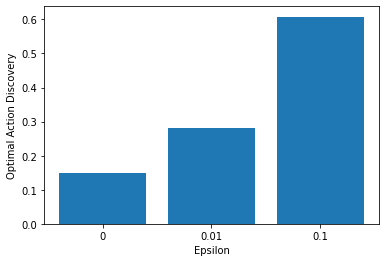

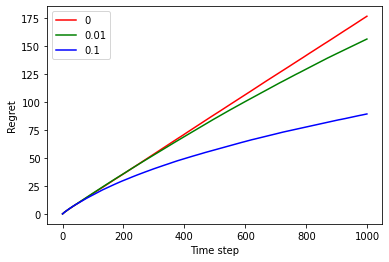

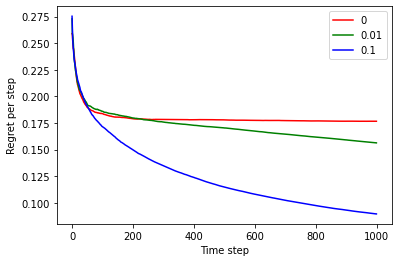

In [ ]:
optimal_found_dict = {}
average_regret_dict = {}
average_regret_per_step_dict = {}
num_runs=2000
total_time_steps_per_run=1000

for eps in [0,0.01,0.1]:
  percent_optimal_found,regret_matrix = simulate(num_runs=num_runs,total_time_steps_per_run=total_time_steps_per_run,eps=eps)
  optimal_found_dict[eps]=percent_optimal_found
  average_regret_by_time_step = [np.mean([trial[i] for trial in regret_matrix]) for i in range(total_time_steps_per_run)]
  average_regret_dict[eps]=average_regret_by_time_step
  average_regret_per_step_dict[eps] = [average_regret_by_time_step[i]/(i+1) for i in range(total_time_steps_per_run)]

opt_xlabel="Epsilon"
plot_optimality_and_regret(optimal_found_dict,average_regret_dict,average_regret_per_step_dict,total_time_steps_per_run,opt_xlabel)

## Written Answer
When ϵ=0, the regret per round seems to plateau around 0.175, so it does not approach 0. When ϵ=0.01, it also seems to be plateauing around 0.150, though this is less clear. For ϵ=0.1, there is no clear plateau, but it also hasn't gotten very close to 0. In the cell below I try running it for 20000 time steps to see if it becomes clearer whether regret per round approaches 0, but it is still unclear because the regret per round further decreases to ~0.04 but the rate of decrease is slowing. So ϵ=0.1 may lead to regret per round approaching 0, but ϵ=0 and ϵ=0.01 do not seem to accomplish this.

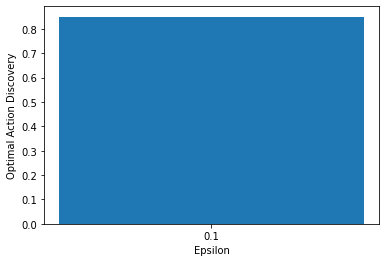

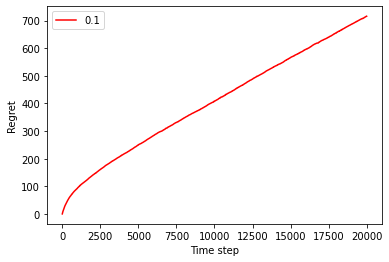

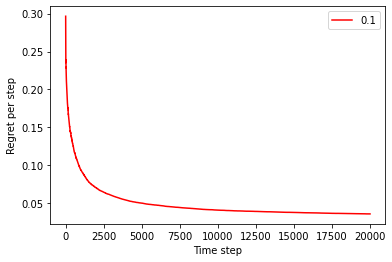

In [ ]:
optimal_found_dict = {}
average_regret_dict = {}
average_regret_per_step_dict = {}
num_runs=100
total_time_steps_per_run=20000

for eps in [0.1]:
  percent_optimal_found,regret_matrix = simulate(num_runs=num_runs,total_time_steps_per_run=total_time_steps_per_run,eps=eps)
  optimal_found_dict[eps]=percent_optimal_found
  average_regret_by_time_step = [np.mean([trial[i] for trial in regret_matrix]) for i in range(total_time_steps_per_run)]
  average_regret_dict[eps]=average_regret_by_time_step
  average_regret_per_step_dict[eps] = [average_regret_by_time_step[i]/(i+1) for i in range(total_time_steps_per_run)]

opt_xlabel="Epsilon"
plot_optimality_and_regret(optimal_found_dict,average_regret_dict,average_regret_per_step_dict,total_time_steps_per_run,opt_xlabel="Epsilon")

## I return to the bonus problems at the end of this notebook.

# Part 3

Optimistic initial values with pure and ϵ-greedy algorithm.

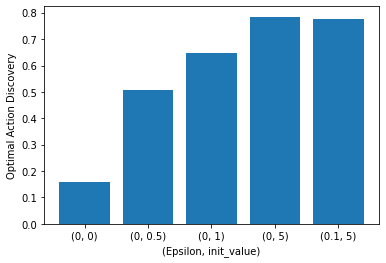

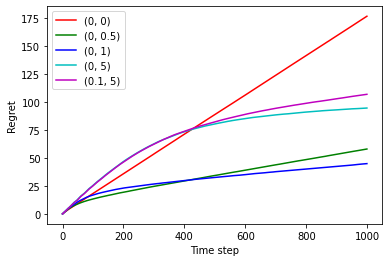

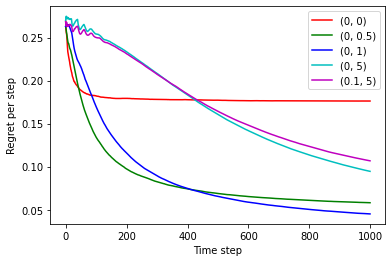

In [ ]:
optimal_found_dict = {}
average_regret_dict = {}
average_regret_per_step_dict = {}
num_runs=2000
total_time_steps_per_run=1000

for (eps,init_value) in [(0,0),(0,0.5),(0,1),(0,5),(0.1,5)]:
  percent_optimal_found,regret_matrix = simulate(num_runs,total_time_steps_per_run,eps,init_value)
  optimal_found_dict[(eps,init_value)]=percent_optimal_found
  average_regret_by_time_step = [np.mean([trial[i] for trial in regret_matrix]) for i in range(total_time_steps_per_run)]
  average_regret_dict[(eps,init_value)]=average_regret_by_time_step
  average_regret_per_step_dict[(eps,init_value)] = [average_regret_by_time_step[i]/(i+1) for i in range(total_time_steps_per_run)]

opt_xlabel = "(Epsilon, init_value)"
plot_optimality_and_regret(optimal_found_dict,average_regret_dict,average_regret_per_step_dict,total_time_steps_per_run,opt_xlabel)

## Written Answer
In terms of finding the optimal action, using 5 as the initial value worked best. This makes sense, because only an initial value of 5 forces the greedy algorithm to explore every option several times before their mean values can dip below those of other strategies that have been performing better so far. However, it takes more time to perform this exploration, and therefore the regret and regret per step are higher for the initial value = 5 cases that the cases when inital value is 0.5 or 1. In the cell below, I increase the number of time steps per run, which shows that with more time the initial value = 5 runs continue to see decreasing regret per round which makes them closer to or better than the 0.5 and 1 runs. 

The spikes in the regret per round plot for the initial value = 5 runs can be explained by the fact that essentially, whatever actions have been chosen so far will not be chosen again until all other actions have been chosen and had their mean reward values diminished as well. This means there is thorough exploration of all action choices for a while, and this leads to significant fluctuations in the regret per round. This stabilizes after all actions have been explored enough to reduce the mean rewards so far to more accurate estimates of the true probabilities.

100%|██████████| 100/100 [00:15<00:00,  6.54it/s]


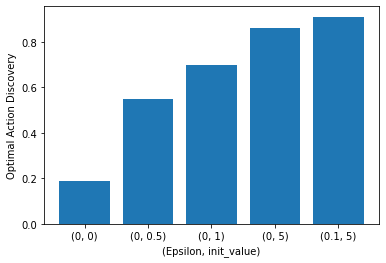

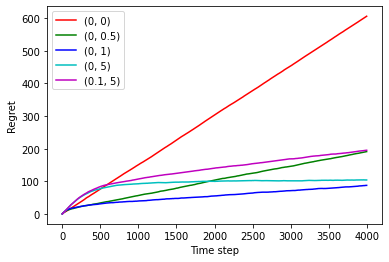

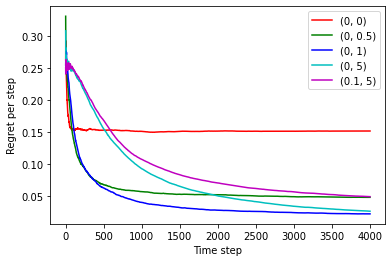

In [ ]:
optimal_found_dict = {}
average_regret_dict = {}
average_regret_per_step_dict = {}
num_runs=100
total_time_steps_per_run=4000

for (eps,init_value) in [(0,0),(0,0.5),(0,1),(0,5),(0.1,5)]:
  percent_optimal_found,regret_matrix = simulate(num_runs,total_time_steps_per_run,eps,init_value)
  optimal_found_dict[(eps,init_value)]=percent_optimal_found
  average_regret_by_time_step = [np.mean([trial[i] for trial in regret_matrix]) for i in range(total_time_steps_per_run)]
  average_regret_dict[(eps,init_value)]=average_regret_by_time_step
  average_regret_per_step_dict[(eps,init_value)] = [average_regret_by_time_step[i]/(i+1) for i in range(total_time_steps_per_run)]

opt_xlabel="(Epsilon, init_value)"
plot_optimality_and_regret(optimal_found_dict,average_regret_dict,average_regret_per_step_dict,total_time_steps_per_run,opt_xlabel)

# Part 4

Upper Confidence Bound algorithm.

No unique best action was learned. max_indices = [5, 7, 10]
No unique best action was learned. max_indices = [1, 14]
No unique best action was learned. max_indices = [3, 19]


 99%|█████████▉| 1987/2000 [03:25<00:01, 10.95it/s]

No unique best action was learned. max_indices = [7, 11]
No unique best action was learned. max_indices = [7, 19]


 99%|█████████▉| 1989/2000 [03:25<00:01,  9.63it/s]

No unique best action was learned. max_indices = [9, 15]


100%|█████████▉| 1993/2000 [03:26<00:00,  8.38it/s]

No unique best action was learned. max_indices = [13, 18]


100%|█████████▉| 1999/2000 [03:26<00:00,  8.16it/s]

No unique best action was learned. max_indices = [1, 5, 16]
No unique best action was learned. max_indices = [5, 17, 19]


100%|██████████| 2000/2000 [03:26<00:00,  9.67it/s]


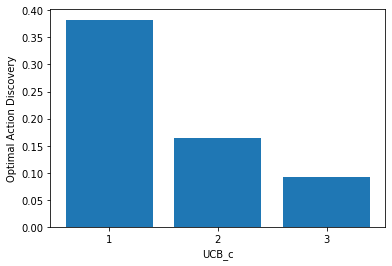

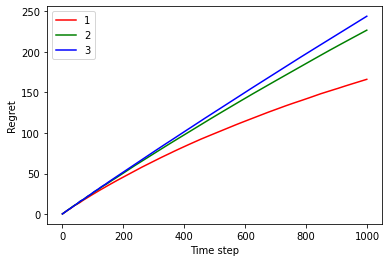

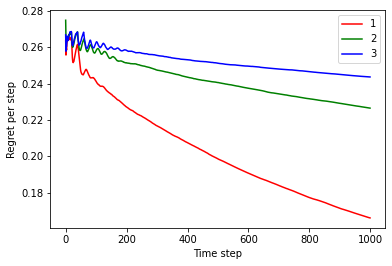

In [ ]:
optimal_found_dict = {}
average_regret_dict = {}
average_regret_per_step_dict = {}
num_runs=2000
total_time_steps_per_run=1000

for ucb_c in [1,2,3]:
  percent_optimal_found,regret_matrix = simulate(num_runs,total_time_steps_per_run,ucb_c=ucb_c)
  optimal_found_dict[ucb_c]=percent_optimal_found
  average_regret_by_time_step = [np.mean([trial[i] for trial in regret_matrix]) for i in range(total_time_steps_per_run)]
  average_regret_dict[ucb_c]=average_regret_by_time_step
  average_regret_per_step_dict[ucb_c] = [average_regret_by_time_step[i]/(i+1) for i in range(total_time_steps_per_run)]

opt_xlabel="UCB_c"
plot_optimality_and_regret(optimal_found_dict,average_regret_dict,average_regret_per_step_dict,total_time_steps_per_run,opt_xlabel)

## Written Answer

Using c=1 worked best here, likely because c=2 and c=3 overweight the importance of exploration and never allow for proper exploitation of the knowledge accrued so far. The spikes early on come from the high degree of exploration incentivized by the UBC action selection mechanism, which causes many fluctuations in the regret per step. These fluctuations last longer for larger values of c, since those incentivize exploration even more strongly.

# Part 5

Gradient method.

100%|██████████| 2000/2000 [02:54<00:00, 11.49it/s]


No unique best action was learned. max_indices = [11, 13]


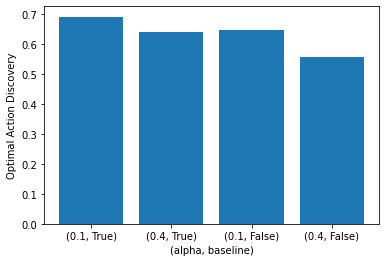

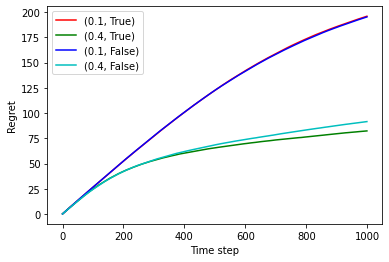

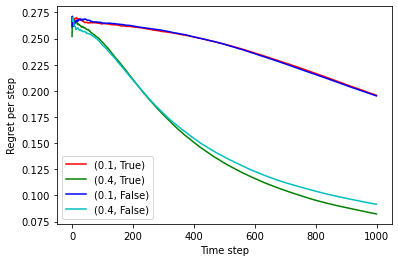

In [ ]:
optimal_found_dict = {}
average_regret_dict = {}
average_regret_per_step_dict = {}
num_runs=2000
total_time_steps_per_run=1000

for (alpha,baseline) in [(0.1,True),(0.4,True),(0.1,False),(0.4,False)]:
  percent_optimal_found,regret_matrix = simulate(num_runs,total_time_steps_per_run,eps=None,init_value=0,ucb_c=None,alpha=alpha,baseline=baseline)
  optimal_found_dict[(alpha,baseline)]=percent_optimal_found
  average_regret_by_time_step = [np.mean([trial[i] for trial in regret_matrix]) for i in range(total_time_steps_per_run)]
  average_regret_dict[(alpha,baseline)]=average_regret_by_time_step
  average_regret_per_step_dict[(alpha,baseline)] = [average_regret_by_time_step[i]/(i+1) for i in range(total_time_steps_per_run)]

opt_xlabel="(alpha, baseline)"
plot_optimality_and_regret(optimal_found_dict,average_regret_dict,average_regret_per_step_dict,total_time_steps_per_run,opt_xlabel)

## Observations

α=0.1 discovers the optimal action more often than α=0.4, but has higher regret and regret per step values. This makes sense, because with a smaller step size the algorithm is more stable but takes longer to find the optimal action. In the cell below, I try extending the number of time steps, and the regret and regret per step of the 0.1 runs get closer to those of the 0.4 runs.

Using the baseline helps find the optimal action more frequently for both values of alpha.

 48%|████▊     | 48/100 [00:23<00:52,  1.01s/it]

No unique best action was learned. max_indices = [0, 9]


100%|██████████| 100/100 [00:48<00:00,  2.07it/s]


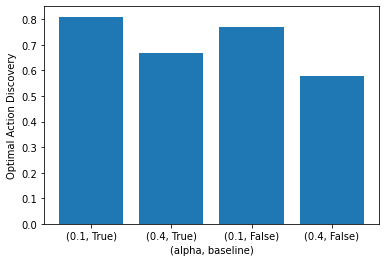

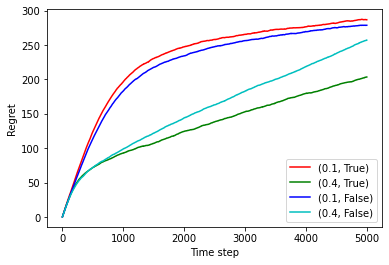

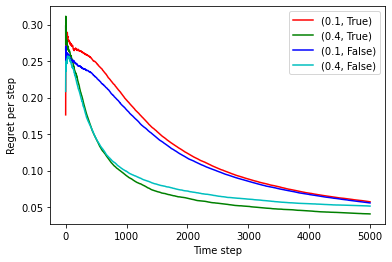

In [ ]:
optimal_found_dict = {}
average_regret_dict = {}
average_regret_per_step_dict = {}
num_runs=100
total_time_steps_per_run=5000

for (alpha,baseline) in [(0.1,True),(0.4,True),(0.1,False),(0.4,False)]:
  percent_optimal_found,regret_matrix = simulate(num_runs,total_time_steps_per_run,eps=None,init_value=0,ucb_c=None,alpha=alpha,baseline=baseline)
  optimal_found_dict[(alpha,baseline)]=percent_optimal_found
  average_regret_by_time_step = [np.mean([trial[i] for trial in regret_matrix]) for i in range(total_time_steps_per_run)]
  average_regret_dict[(alpha,baseline)]=average_regret_by_time_step
  average_regret_per_step_dict[(alpha,baseline)] = [average_regret_by_time_step[i]/(i+1) for i in range(total_time_steps_per_run)]

opt_xlabel="(alpha, baseline)"
plot_optimality_and_regret(optimal_found_dict,average_regret_dict,average_regret_per_step_dict,total_time_steps_per_run,opt_xlabel)

# Bonus Problems

## Completely random choice for the first ϵT runs

In [ ]:
def simulate_random_first(num_runs,total_time_steps_per_run,eps,init_value=0):
  num_optimal_found = 0
  regret_matrix = []
  
  for i in tqdm(range(num_runs)):
    
    true_probs = np.random.beta(1,7,20)
    max_prob, optimal_index = max(true_probs), np.argmax(true_probs)
    mean_rewards = [init_value]*20
    action_attempts = [0]*20 if init_value == 0 else [1]*20 # This seems reasonable for getting more exploration when using optimistic initial values
    regret_list = []
    total_reward = 0
    for t in range(total_time_steps_per_run):
      max_indices = [idx for idx, val in enumerate(mean_rewards) if val == max(mean_rewards)]
      # action_idx = np.random.randint(20) if np.random.rand() < eps else np.random.choice(max_indices)
      action_idx = np.random.randint(20) if t < eps*total_time_steps_per_run else np.random.choice(max_indices)
      
      reward = 1 if np.random.rand() < true_probs[action_idx] else 0
      total_reward += reward
      regret = max_prob*(t+1) - total_reward
      regret_list.append(regret)


      mean_rewards[action_idx] = (action_attempts[action_idx]*mean_rewards[action_idx] + reward)/(action_attempts[action_idx]+1)
      action_attempts[action_idx] += 1


    learned_optimal_index = np.argmax(mean_rewards)
    optimal_found = True if optimal_index == learned_optimal_index else False
    max_indices = [idx for idx, val in enumerate(mean_rewards) if val == max(mean_rewards)]
    if len(max_indices) > 1: print(f"No unique best action was learned. max_indices = {max_indices}")

    if optimal_found:
      num_optimal_found += 1
    regret_matrix.append(regret_list)
  percent_optimal_found = num_optimal_found/num_runs
  return percent_optimal_found,regret_matrix

 26%|██▌       | 518/2000 [00:22<00:46, 31.54it/s]

No unique best action was learned. max_indices = [1, 11]


100%|██████████| 2000/2000 [01:19<00:00, 25.25it/s]


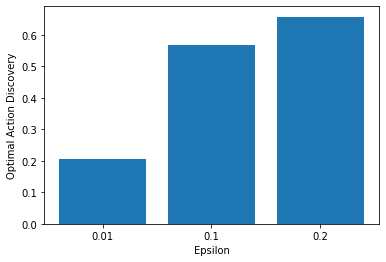

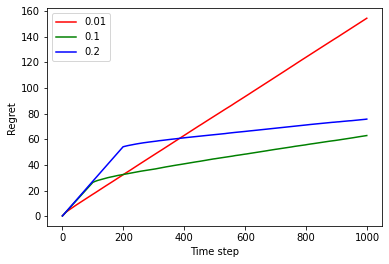

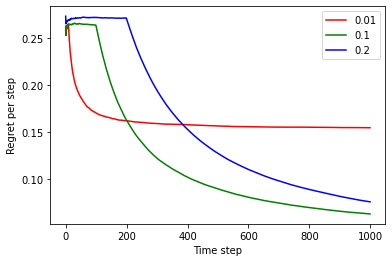

In [ ]:
optimal_found_dict = {}
average_regret_dict = {}
average_regret_per_step_dict = {}
num_runs=2000
total_time_steps_per_run=1000

for eps in [.01, 0.1, 0.2]:
  percent_optimal_found,regret_matrix = simulate_random_first(num_runs,total_time_steps_per_run,eps=eps)
  optimal_found_dict[eps]=percent_optimal_found
  average_regret_by_time_step = [np.mean([trial[i] for trial in regret_matrix]) for i in range(total_time_steps_per_run)]
  average_regret_dict[eps]=average_regret_by_time_step
  average_regret_per_step_dict[eps] = [average_regret_by_time_step[i]/(i+1) for i in range(total_time_steps_per_run)]

opt_xlabel="Epsilon"
plot_optimality_and_regret(optimal_found_dict,average_regret_dict,average_regret_per_step_dict,total_time_steps_per_run,opt_xlabel)

## Decreasing ϵ

In [ ]:
def simulate_decreasing_eps(num_runs,total_time_steps_per_run,k,init_value=0):
  num_optimal_found = 0
  regret_matrix = []
  
  for i in tqdm(range(num_runs)):
    
    true_probs = np.random.beta(1,7,20)
    max_prob, optimal_index = max(true_probs), np.argmax(true_probs)
    mean_rewards = [init_value]*20
    action_attempts = [0]*20 if init_value == 0 else [1]*20 # This seems reasonable for getting more exploration when using optimistic initial values
    regret_list = []
    total_reward = 0
    for t in range(total_time_steps_per_run):
      max_indices = [idx for idx, val in enumerate(mean_rewards) if val == max(mean_rewards)]
      eps=np.exp(-k*t)
      action_idx = np.random.randint(20) if np.random.rand() < eps else np.random.choice(max_indices)
      
      reward = 1 if np.random.rand() < true_probs[action_idx] else 0
      total_reward += reward
      regret = max_prob*(t+1) - total_reward
      regret_list.append(regret)

      mean_rewards[action_idx] = (action_attempts[action_idx]*mean_rewards[action_idx] + reward)/(action_attempts[action_idx]+1)
      action_attempts[action_idx] += 1

    learned_optimal_index = np.argmax(mean_rewards)
    optimal_found = True if optimal_index == learned_optimal_index else False
    max_indices = [idx for idx, val in enumerate(mean_rewards) if val == max(mean_rewards)]
    if len(max_indices) > 1: print(f"No unique best action was learned. max_indices = {max_indices}")

    if optimal_found:
      num_optimal_found += 1
    regret_matrix.append(regret_list)
  percent_optimal_found = num_optimal_found/num_runs
  return percent_optimal_found,regret_matrix

100%|██████████| 2000/2000 [01:43<00:00, 19.36it/s]


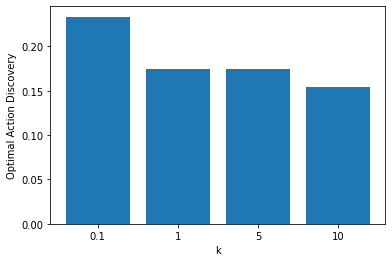

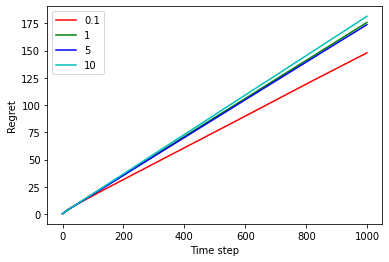

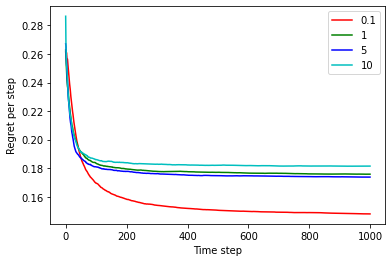

In [ ]:
optimal_found_dict = {}
average_regret_dict = {}
average_regret_per_step_dict = {}
num_runs=2000
total_time_steps_per_run=1000

for k in [0.1, 1, 5, 10]:
  percent_optimal_found,regret_matrix = simulate_decreasing_eps(num_runs,total_time_steps_per_run,k=k)
  optimal_found_dict[k]=percent_optimal_found
  average_regret_by_time_step = [np.mean([trial[i] for trial in regret_matrix]) for i in range(total_time_steps_per_run)]
  average_regret_dict[k]=average_regret_by_time_step
  average_regret_per_step_dict[k] = [average_regret_by_time_step[i]/(i+1) for i in range(total_time_steps_per_run)]

opt_xlabel="k"
plot_optimality_and_regret(optimal_found_dict,average_regret_dict,average_regret_per_step_dict,total_time_steps_per_run,opt_xlabel)

k needs to be smaller to allow sufficient exploration: in the cell below, I reduce it to 0.001 and 0.01, and it works better.

100%|██████████| 200/200 [00:36<00:00,  5.46it/s]


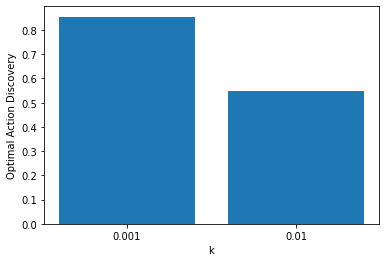

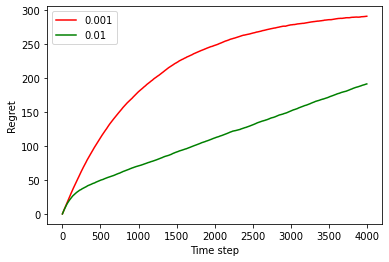

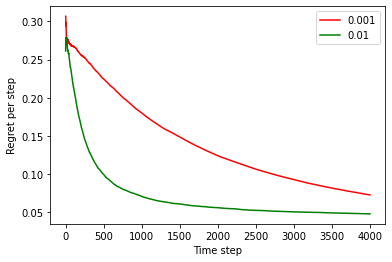

In [ ]:
optimal_found_dict = {}
average_regret_dict = {}
average_regret_per_step_dict = {}
num_runs=200
total_time_steps_per_run=4000

for k in [0.001,0.01]:
  percent_optimal_found,regret_matrix = simulate_decreasing_eps(num_runs,total_time_steps_per_run,k=k)
  optimal_found_dict[k]=percent_optimal_found
  average_regret_by_time_step = [np.mean([trial[i] for trial in regret_matrix]) for i in range(total_time_steps_per_run)]
  average_regret_dict[k]=average_regret_by_time_step
  average_regret_per_step_dict[k] = [average_regret_by_time_step[i]/(i+1) for i in range(total_time_steps_per_run)]

opt_xlabel="k"
plot_optimality_and_regret(optimal_found_dict,average_regret_dict,average_regret_per_step_dict,total_time_steps_per_run,opt_xlabel)